In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

# Résultats modèle Lidar
### Chargement

In [99]:
# PREDICTIONS_FOLDER_VAL = Path("/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-06/17-37-05")
# PREDICTIONS_FOLDER_TEST = Path("/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-06/17-36-40")
# df_val = pd.read_csv(PREDICTIONS_FOLDER_VAL / "predictions.csv")
# df_test = pd.read_csv(PREDICTIONS_FOLDER_TEST / "predictions.csv")
# df = pd.concat([df_val, df_test])
UNION_PREDICTIONS_DIR = Path("/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-16/16-09-17/")
df = pd.read_csv(UNION_PREDICTIONS_DIR / "predictions.csv")
print(df.shape)

mapping = {0: "FF1-09-09_Hêtre",
  1: "FF1-10-10_Châtaignier",
  2: "FF1-14-14_Robinier",
  3: "FF1G01-01_Chêne_décidus",
  4: "FF1G06-06_Chêne_sempervirent",
  5: "FF2-51-51_Pin_maritime",
  6: "FF2-52-52_Pin_sylvestre",
  7: "FF2-57-57_Pin_alep",
  8: "FF2-63-63-Mélèze",
  9: "FF2-64-64_Douglas",
  10: "FF2G53-53_Pin_laricio_Pin_noir",
  11: "FF2G61-61_Sapin-Epicéa"}
df["targets"] = df["targets"].apply(lambda t: mapping[t])
df["preds"] = df["preds"].apply(lambda t: mapping[t])
df.head()

(5910, 3)


,patch_num,preds,targets
0,00328_02538,FF1-09-09_Hêtre,FF2-52-52_Pin_sylvestre
1,00123_01544,FF2G53-53_Pin_laricio_Pin_noir,FF2G53-53_Pin_laricio_Pin_noir
2,00451_00038,FF1-09-09_Hêtre,FF2-52-52_Pin_sylvestre
3,00328_02825,FF2-64-64_Douglas,FF2-52-52_Pin_sylvestre
4,00213_00121,FF1G06-06_Chêne_sempervirent,FF1G06-06_Chêne_sempervirent


In [35]:
df.targets.unique()

array(['FF2-52-52_Pin_sylvestre', 'FF2G53-53_Pin_laricio_Pin_noir',
       'FF1G06-06_Chêne_sempervirent', 'FF2-64-64_Douglas',
       'FF1G01-01_Chêne_décidus', 'FF2G61-61_Sapin-Epicéa',
       'FF1-09-09_Hêtre', 'FF2-63-63-Mélèze', 'FF1-14-14_Robinier',
       'FF2-57-57_Pin_alep', 'FF1-10-10_Châtaignier'], dtype=object)

### Aggrégation au polygone

In [95]:
gdf = gpd.read_file("/mnt/store-lidarhd/projet-LHD/IA/BDForet/Data/PureForestID/metadata/PureForestID-patches.gpkg")
gdf = gdf[gdf.split.isin(["test","val"])]
gdf = gdf[["split", "patch_num", "bdforet_identifier","bdforet_cat_code", "bdforet_cat_name","inventory_species_label", "geometry"]]
print(gdf.columns)
gdf.head()

Index(['split', 'patch_num', 'bdforet_identifier', 'bdforet_cat_code',
       'bdforet_cat_name', 'inventory_species_label', 'geometry'],
      dtype='object')


,split,patch_num,bdforet_identifier,bdforet_cat_code,bdforet_cat_name,inventory_species_label,geometry
0,val,00035_00000,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850350.00000 6529250.00000, 850400.0..."
1,val,00035_00001,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850350.00000 6529300.00000, 850400.0..."
2,val,00035_00002,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850400.00000 6529300.00000, 850450.0..."
3,val,00035_00003,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850450.00000 6529300.00000, 850500.0..."
4,val,00035_00004,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850500.00000 6529300.00000, 850550.0..."


In [100]:
merge = gdf.merge(df, left_on="patch_num", right_on="patch_num", how="inner")
merge["accurate"] = merge["targets"] == merge["preds"]
print(len(merge))
merge.to_file(UNION_PREDICTIONS_DIR / "PureForestID-patches-with-their-error.json")
merge.head()

5910


,split,patch_num,bdforet_identifier,bdforet_cat_code,bdforet_cat_name,inventory_species_label,geometry,preds,targets,accurate
0,val,00035_00003,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850450.00000 6529300.00000, 850500.0...",FF1-14-14_Robinier,FF1-14-14_Robinier,True
1,val,00035_00009,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850450.00000 6529500.00000, 850500.0...",FF1-14-14_Robinier,FF1-14-14_Robinier,True
2,val,00035_00011,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((850500.00000 6529550.00000, 850550.0...",FF1-14-14_Robinier,FF1-14-14_Robinier,True
3,val,00056_00003,FORESTIE0000000000100104,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((856350.00000 6530050.00000, 856400.0...",FF1-14-14_Robinier,FF1-14-14_Robinier,True
4,val,00056_00006,FORESTIE0000000000100104,FF1-14-14,Forêt fermée de robinier pur,14,"POLYGON ((857050.00000 6530000.00000, 857100.0...",FF1-14-14_Robinier,FF1-14-14_Robinier,True


In [ ]:
groups = merge.groupby(["bdforet_identifier","bdforet_cat_code","targets","preds"]).size().reset_index()
pivot = groups.pivot(index=["bdforet_identifier","targets"],columns="preds",values=0).fillna(0).astype(int)
pivot["consensus"] = pivot.idxmax(axis=1)
pivot = pivot.reset_index()
pivot["accurate"] = pivot["consensus"] == pivot["targets"]
pivot.to_csv(UNION_PREDICTIONS_DIR/"predictions-pivot-by-polygon.csv")
pivot

preds,bdforet_identifier,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate
0,FORESTIE0000000000100093,FF1-14-14_Robinier,0,0,12,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
1,FORESTIE0000000000100104,FF1-14-14_Robinier,0,0,36,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
2,FORESTIE0000000000100240,FF1-14-14_Robinier,0,0,9,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
3,FORESTIE0000000000401455,FF1G01-01_Chêne_décidus,0,0,83,46,33,3,0,0,0,0,0,FF1-14-14_Robinier,False
4,FORESTIE0000000000402323,FF1G01-01_Chêne_décidus,130,31,0,651,1,2,0,0,0,0,0,FF1G01-01_Chêne_décidus,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,FORESTIE0000000008208414,FF1-14-14_Robinier,0,0,6,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
89,FORESTIE0000000008208450,FF1-14-14_Robinier,0,0,4,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
90,FORESTIE0000000008208460,FF1-14-14_Robinier,0,0,6,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
91,FORESTIE0000000008210212,FF1G01-01_Chêne_décidus,1,0,3877,1044,0,1,0,1,0,1,0,FF1-14-14_Robinier,False


## Accuracies et Matrice de Confusion

In [82]:
synthesis = pivot.groupby("targets").agg({"accurate":"mean","bdforet_identifier":"size"}).round(2)
synthesis = synthesis.rename(columns={"accurate":"accuracy","bdforet_identifier":"num_bdforet_polygons"})
synthesis.to_csv(UNION_PREDICTIONS_DIR/"predictions-accuracy-by-class.csv")
synthesis


preds,accuracy,num_bdforet_polygons
targets,,
FF1-09-09_Hêtre,0.83,1976
FF1-10-10_Châtaignier,0.58,426
FF1-14-14_Robinier,0.92,759
FF1G01-01_Chêne_décidus,0.58,15609
FF1G06-06_Chêne_sempervirent,0.92,2210
FF2-52-52_Pin_sylvestre,0.15,5928
FF2-57-57_Pin_alep,0.80,707
FF2-63-63-Mélèze,0.99,824
FF2-64-64_Douglas,0.73,2045


In [83]:
synthesis

preds,accuracy,num_bdforet_polygons
targets,,
FF1-09-09_Hêtre,0.83,1976
FF1-10-10_Châtaignier,0.58,426
FF1-14-14_Robinier,0.92,759
FF1G01-01_Chêne_décidus,0.58,15609
FF1G06-06_Chêne_sempervirent,0.92,2210
FF2-52-52_Pin_sylvestre,0.15,5928
FF2-57-57_Pin_alep,0.80,707
FF2-63-63-Mélèze,0.99,824
FF2-64-64_Douglas,0.73,2045


In [84]:
global_accuracy_row = [{
    "targets": "all",
    "accuracy": 1,
    "num_bdforet_polygons": synthesis["num_bdforet_polygons"].sum(),
}]
pd.concat([pd.DataFrame(data=global_accuracy_row), synthesis.reset_index()]).reset_index(drop=True)
# pd.DataFrame(data=global_accuracy_row)

,targets,accuracy,num_bdforet_polygons
0,all,1.00,41889
1,FF1-09-09_Hêtre,0.83,1976
2,FF1-10-10_Châtaignier,0.58,426
3,FF1-14-14_Robinier,0.92,759
4,FF1G01-01_Chêne_décidus,0.58,15609
5,FF1G06-06_Chêne_sempervirent,0.92,2210
6,FF2-52-52_Pin_sylvestre,0.15,5928
7,FF2-57-57_Pin_alep,0.80,707
8,FF2-63-63-Mélèze,0.99,824
9,FF2-64-64_Douglas,0.73,2045


In [85]:
# accuracy at the polygon level
OK = len(pivot[pivot.accurate])
NOK = len(pivot[~pivot.accurate])

print(f"Accuracy = {OK/(OK+NOK)}")
synthesis.sort_values("accuracy",ascending=False)

Accuracy = 0.6667144118981116


preds,accuracy,num_bdforet_polygons
targets,,
FF2-63-63-Mélèze,0.99,824
FF2G61-61_Sapin-Epicéa,0.98,3585
FF1-14-14_Robinier,0.92,759
FF1G06-06_Chêne_sempervirent,0.92,2210
FF2G53-53_Pin_laricio_Pin_noir,0.90,7820
FF1-09-09_Hêtre,0.83,1976
FF2-57-57_Pin_alep,0.80,707
FF2-64-64_Douglas,0.73,2045
FF1-10-10_Châtaignier,0.58,426


In [86]:
# erreurs
non_accurates = pivot[~pivot.accurate].sort_values("targets")
non_accurates

preds,bdforet_identifier,targets,geometry,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate
20228,FORESTIE0000000004302294,FF1-09-09_Hêtre,"POLYGON ((738850.00000 6416100.00000, 738900.0...",0,0,0,1,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
1550,FORESTIE0000000000403437,FF1-09-09_Hêtre,"POLYGON ((989600.00000 6327950.00000, 989650.0...",0,0,0,1,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
1851,FORESTIE0000000000522889,FF1-09-09_Hêtre,"POLYGON ((946800.00000 6396750.00000, 946850.0...",0,0,1,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
1854,FORESTIE0000000000522889,FF1-09-09_Hêtre,"POLYGON ((946850.00000 6396650.00000, 946900.0...",0,0,1,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
1860,FORESTIE0000000000522889,FF1-09-09_Hêtre,"POLYGON ((946750.00000 6396700.00000, 946800.0...",0,0,1,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29524,FORESTIE0000000004835354,FF2G61-61_Sapin-Epicéa,"POLYGON ((746300.00000 6399150.00000, 746350.0...",1,0,0,0,0,0,0,0,0,0,0,FF1-09-09_Hêtre,False
29525,FORESTIE0000000004835354,FF2G61-61_Sapin-Epicéa,"POLYGON ((746250.00000 6399150.00000, 746300.0...",1,0,0,0,0,0,0,0,0,0,0,FF1-09-09_Hêtre,False
29556,FORESTIE0000000004835354,FF2G61-61_Sapin-Epicéa,"POLYGON ((746300.00000 6399400.00000, 746350.0...",0,0,0,0,0,1,0,0,0,0,0,FF2-52-52_Pin_sylvestre,False
29436,FORESTIE0000000004835354,FF2G61-61_Sapin-Epicéa,"POLYGON ((746650.00000 6399450.00000, 746700.0...",0,0,0,0,0,1,0,0,0,0,0,FF2-52-52_Pin_sylvestre,False


In [92]:
# Lien entre erreur et taille de polygone -> pas vraiment.
non_accurates["num_patches_in_polygon"] = non_accurates[[c for c in non_accurates.columns if c.startswith("FF")]].sum(axis=1)
non_accurates[["targets","consensus","num_patches_in_polygon"]]

preds,targets,consensus,num_patches_in_polygon
20228,FF1-09-09_Hêtre,FF1G01-01_Chêne_décidus,1
1550,FF1-09-09_Hêtre,FF1G01-01_Chêne_décidus,1
1851,FF1-09-09_Hêtre,FF1-14-14_Robinier,1
1854,FF1-09-09_Hêtre,FF1-14-14_Robinier,1
1860,FF1-09-09_Hêtre,FF1-14-14_Robinier,1
...,...,...,...
29524,FF2G61-61_Sapin-Epicéa,FF1-09-09_Hêtre,1
29525,FF2G61-61_Sapin-Epicéa,FF1-09-09_Hêtre,1
29556,FF2G61-61_Sapin-Epicéa,FF2-52-52_Pin_sylvestre,1
29436,FF2G61-61_Sapin-Epicéa,FF2-52-52_Pin_sylvestre,1


In [88]:
# Confusion matrix at polygon level
counts = pivot.groupby(["targets","consensus"]).size().reset_index().rename(columns={0:"count"})
cm = counts.pivot(index="targets",columns="consensus",values="count").fillna(0).astype(int)
cm

consensus,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa
targets,,,,,,,,,,,
FF1-09-09_Hêtre,1639,38,125,139,0,5,0,29,0,1,0
FF1-10-10_Châtaignier,7,248,78,51,39,0,0,0,0,3,0
FF1-14-14_Robinier,0,28,702,2,0,0,0,0,3,0,24
FF1G01-01_Chêne_décidus,140,131,5794,9011,159,300,49,1,20,4,0
FF1G06-06_Chêne_sempervirent,0,22,2,150,2023,3,1,0,9,0,0
FF2-52-52_Pin_sylvestre,1025,0,84,1486,26,891,549,21,703,1138,5
FF2-57-57_Pin_alep,0,24,0,0,26,37,563,3,54,0,0
FF2-63-63-Mélèze,3,0,0,3,0,4,0,814,0,0,0
FF2-64-64_Douglas,24,19,123,3,8,0,22,0,1501,209,136


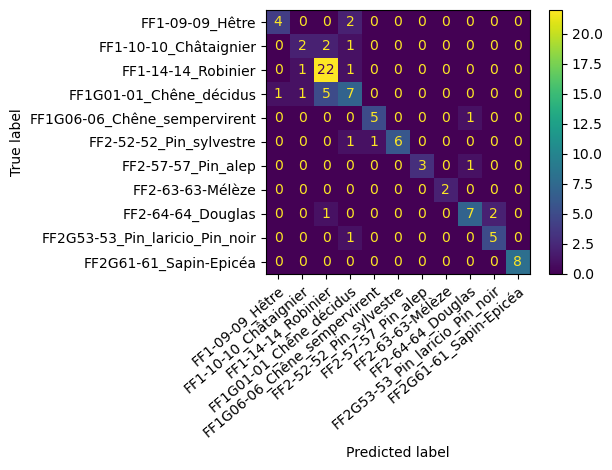

In [15]:
ConfusionMatrixDisplay(cm.values, display_labels=cm.index.values).plot()
import matplotlib.pyplot as plt
plt.xticks(rotation = 40,  rotation_mode="anchor",ha='right') # Rotates X-Axis Ticks by 45-degrees
# plt.show()
plt.tight_layout()
plt.savefig(UNION_PREDICTIONS_DIR / "CM-by-polygon-val-and-test.png")

## TOP-2 accuracies et Matrice de Confusion

In [16]:
pivot["second_consensus"] = pivot[[c for c in pivot.columns if c.startswith("FF")]].apply(lambda row: row.nlargest(2).index[-1], axis=1)
pivot["accurate_top2"] =  (pivot["second_consensus"] == pivot["targets"]) | pivot["accurate"]

synthesis = pivot.groupby("targets").agg({"accurate_top2":"mean","bdforet_identifier":"size"}).round(2)
synthesis = synthesis.rename(columns={"accurate_top2":"accuracy_top2","bdforet_identifier":"num_bdforet_polygons"})
synthesis.to_csv(UNION_PREDICTIONS_DIR/"predictions-top2-accuracy-by-class.csv")
synthesis.sort_values("accuracy_top2",ascending=False)

preds,accuracy_top2,num_bdforet_polygons
targets,,
FF1G06-06_Chêne_sempervirent,1.00,6
FF2-57-57_Pin_alep,1.00,4
FF2-63-63-Mélèze,1.00,2
FF2G61-61_Sapin-Epicéa,1.00,8
FF1-14-14_Robinier,0.92,24
FF2-52-52_Pin_sylvestre,0.88,8
FF1-09-09_Hêtre,0.83,6
FF2G53-53_Pin_laricio_Pin_noir,0.83,6
FF1G01-01_Chêne_décidus,0.79,14


In [17]:
# accuracy at the polygon level
OK = len(pivot[pivot.accurate_top2])
NOK = len(pivot[~pivot.accurate_top2])
OK/(OK+NOK)

0.8494623655913979

## Aggrégation aux polygones initiaux

In [18]:
annotations = gpd.read_file("/mnt/store-lidarhd/projet-LHD/IA/BDForet/Data/PureForestID/metadata/PureForestID-annotations.gpkg")
# gdf = gdf[gdf.split.isin(["test","val"])]
# gdf = gdf[["bdforet_identifier", "patch_num", "bdforet_identifier","bdforet_cat_code", "bdforet_cat_name","inventory_species_label", ]]
print(annotations.columns)
print(len(annotations))
annotations.head()

Index(['inventory_species_label', 'french_department_id',
       'rgbnir_imagery_year', 'bdforet_identifier', 'if_idp', 'index',
       'geometry'],
      dtype='object')
606


,inventory_species_label,french_department_id,rgbnir_imagery_year,bdforet_identifier,if_idp,index,geometry
0,14,38,2021,FORESTIE0000000003807719,None,polygon_id_0000,"POLYGON ((847835.000 6496796.300, 847836.800 6..."
1,10,46,2019,FORESTIE0000000004607749,1604803,polygon_id_0001,"POLYGON ((575671.409 6405360.047, 575662.320 6..."
2,09,15,2020,FORESTIE0000000001505240,1114880,polygon_id_0002,"POLYGON ((657240.199 6438851.684, 657260.651 6..."
3,51,40,2021,FORESTIE0000000004030982,1103823,polygon_id_0003,"POLYGON ((458895.878 6336277.228, 458905.620 6..."
4,57A,24,2021,None,None,polygon_id_0004,"MULTIPOLYGON (((917888.499 6245709.976, 917892..."


In [19]:
# We merge when a bd foret polygon was splitted into n polygons of the same species
annotations = annotations.dissolve(by=["inventory_species_label","bdforet_identifier"], as_index=False)
annotations

,inventory_species_label,bdforet_identifier,geometry,french_department_id,rgbnir_imagery_year,if_idp,index
0,02,FORESTIE0000000001504492,"POLYGON ((650589.255 6474224.790, 650586.015 6...",15,2020,1118642,polygon_id_0413
1,02,FORESTIE0000000002446444,"POLYGON ((539813.712 6497050.060, 539831.336 6...",24,2021,1629768,polygon_id_0430
2,02,FORESTIE0000000003215110,"POLYGON ((523300.500 6329284.500, 523307.820 6...",32,2019,1118152,polygon_id_0389
3,02,FORESTIE0000000004018714,"POLYGON ((464953.738 6325849.944, 464965.732 6...",40,2021,1126100,polygon_id_0503
4,02,FORESTIE0000000008209845,"POLYGON ((556092.800 6331011.000, 556093.300 6...",82,2019,1628880,polygon_id_0151
...,...,...,...,...,...,...,...
420,64,FORESTIE0000000006907469,"MULTIPOLYGON (((819186.322 6571409.873, 819174...",69,2020,1111088,polygon_id_0156
421,64,FORESTIE0000000008721626,"POLYGON ((584949.773 6516474.790, 584965.444 6...",87,2020,1123804,polygon_id_0262
422,65,FORESTIE0000000001621704,"POLYGON ((473706.511 6469995.554, 473752.003 6...",16,2020,1608496,polygon_id_0108
423,71,FORESTIE0000000003417825,"POLYGON ((747887.480 6304378.939, 747974.674 6...",34,2021,1120364,polygon_id_0552


In [20]:
annotations_cm = annotations.merge(pivot, on="bdforet_identifier")
annotations_cm.to_file(UNION_PREDICTIONS_DIR / "bdforet_annotations_and_their_confusion.geojson")
print(UNION_PREDICTIONS_DIR)
annotations_cm

/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-06/17-36-40


,inventory_species_label,bdforet_identifier,geometry,french_department_id,rgbnir_imagery_year,if_idp,index,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,...,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate,second_consensus,accurate_top2
0,02,FORESTIE0000000002446444,"POLYGON ((539813.712 6497050.060, 539831.336 6...",24,2021,1629768,polygon_id_0430,FF1G01-01_Chêne_décidus,1,1,...,0,0,0,1,0,0,FF1-09-09_Hêtre,False,FF1-10-10_Châtaignier,False
1,02,FORESTIE0000000003215110,"POLYGON ((523300.500 6329284.500, 523307.820 6...",32,2019,1118152,polygon_id_0389,FF1G01-01_Chêne_décidus,0,0,...,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,True,FF1-14-14_Robinier,True
2,03,FORESTIE0000000001504926,"POLYGON ((665899.589 6413824.735, 665884.909 6...",15,2020,1103343,polygon_id_0305,FF1G01-01_Chêne_décidus,0,0,...,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,True,FF1-09-09_Hêtre,True
3,03,FORESTIE0000000007119243,"POLYGON ((786277.233 6573804.909, 786290.995 6...",71,2020,1625081,polygon_id_0444,FF1G01-01_Chêne_décidus,1,0,...,0,0,0,16,0,0,FF1-14-14_Robinier,False,FF2-64-64_Douglas,False
4,04,FORESTIE0000000003809798,"POLYGON ((867330.300 6478063.000, 867299.475 6...",38,2021,1618186,polygon_id_0177,FF1G01-01_Chêne_décidus,0,0,...,0,0,0,0,0,0,FF1-14-14_Robinier,False,FF1-09-09_Hêtre,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,63,FORESTIE0000000000526662,"POLYGON ((977893.800 6415839.000, 977894.000 6...",05,2018,1638178,polygon_id_0204,FF2-63-63-Mélèze,3,0,...,4,0,534,0,0,0,FF2-63-63-Mélèze,True,FF2-52-52_Pin_sylvestre,True
89,64,FORESTIE0000000002323832,"MULTIPOLYGON (((648843.000 6520010.800, 648843...",23,2020,1103890,polygon_id_0114,FF2-64-64_Douglas,0,2,...,0,0,0,38,0,0,FF2-64-64_Douglas,True,FF1-10-10_Châtaignier,True
90,64,FORESTIE0000000006905997,"MULTIPOLYGON (((814002.000 6534702.300, 814000...",69,2020,1110357,polygon_id_0272,FF2-64-64_Douglas,8,0,...,0,0,0,18,9,10,FF2-64-64_Douglas,True,FF1-14-14_Robinier,True
91,64,FORESTIE0000000006906715,"MULTIPOLYGON (((813787.473 6566249.779, 813767...",69,2020,1654380,polygon_id_0159,FF2-64-64_Douglas,1,0,...,0,0,0,40,0,35,FF2-64-64_Douglas,True,FF2G61-61_Sapin-Epicéa,True


# Comparaison avec résultats Image

In [195]:
import ast
# Rename to order similarly
remapper = {"Chêne sempervirent":"FF1G06-06_Chêne_sempervirent",
"Pin d'Alep":"FF2-57-57_Pin_alep",
"Mélèze":"FF2-63-63-Mélèze",
"Epicéa":"FF2G61-61_Sapin-Epicéa",
"Sapin":"FF2G61-61_Sapin-Epicéa",
"Robinier":"FF1-14-14_Robinier",
"Pin sylvestre":"FF2-52-52_Pin_sylvestre",
"Hêtre":"FF1-09-09_Hêtre",
"Pin maritime":"FF2-51-51_Pin_maritime",
"Pin laricio, pin noir":"FF2G53-53_Pin_laricio_Pin_noir",
"Chêne décidu":"FF1G01-01_Chêne_décidus",
"Douglas":"FF2-64-64_Douglas",
"Chataîgnier":"FF1-10-10_Châtaignier",
'Non forêt':'Non forêt'
}

FLAIR2_RESULTS_DIR = Path("/mnt/store-lidarhd/projet-LHD/IA/Analyses/20231102_foret_analyses_predictions/Expé_PureForest_FLAIR2/")
df_flair2 = gpd.read_file(FLAIR2_RESULTS_DIR / "predictions_pylgone_version_1_val_test.gpkg")
df_flair2["actual_essence_bdforetv3"] = df_flair2["actual_essence_bdforetv3"].apply(lambda x : remapper[x])
df_flair2["predicted_essence_bdforetv3"] = df_flair2["predicted_essence_bdforetv3"].apply(lambda x : remapper[x])
df_flair2["percent_votes"] = df_flair2["percent_votes"].apply(lambda votes : {remapper[key]:value/100 for key,value in ast.literal_eval(votes).items()})
df_flair2["absolute_votes"] = df_flair2["absolute_votes"].apply(lambda votes : {remapper[key]:value for key,value in ast.literal_eval(votes).items()})
df_flair2.head()

,annotation_id,actual_class,predicted_class,actual_code_essence_inventaire,actual_essence_inventaire,actual_code_essence_bdforetv3,actual_essence_bdforetv3,predicted_code_essence_bdforetv3,predicted_essence_bdforetv3,absolute_votes,percent_votes,annotation_area_km2,geometry
0,17,3,0,10,Châtaignier,10,FF1-10-10_Châtaignier,01,FF1G01-01_Chêne_décidus,"{'FF1G01-01_Chêne_décidus': 2280136.0, 'FF1G06...",{'FF1G01-01_Chêne_décidus': 0.6443000000000001...,0.069641,"POLYGON ((894711.861 6472455.683, 894725.204 6..."
1,19,1,1,06,Chêne vert,06,FF1G06-06_Chêne_sempervirent,06,FF1G06-06_Chêne_sempervirent,"{'FF1G01-01_Chêne_décidus': 61.0, 'FF1G06-06_C...","{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...",1.233156,"POLYGON ((793556.796 6303702.811, 793562.094 6..."
2,22,2,11,09,Hêtre,09,FF1-09-09_Hêtre,63,FF2-63-63-Mélèze,"{'FF1G01-01_Chêne_décidus': 4.0, 'FF1G06-06_Ch...","{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...",0.147476,"POLYGON ((948583.906 6403477.780, 948586.705 6..."
3,23,1,5,06,Chêne vert,06,FF1G06-06_Chêne_sempervirent,51,FF2-51-51_Pin_maritime,"{'FF1G01-01_Chêne_décidus': 1.0, 'FF1G06-06_Ch...","{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...",0.087319,"POLYGON ((1197402.882 6078241.052, 1197405.335..."
4,27,6,6,52,Pin sylvestre,52,FF2-52-52_Pin_sylvestre,52,FF2-52-52_Pin_sylvestre,"{'FF1G01-01_Chêne_décidus': 24905697.0, 'FF1G0...",{'FF1G01-01_Chêne_décidus': 0.1397199999999999...,5.189879,"POLYGON ((1037876.825 6328044.487, 1037867.300..."


In [196]:
# Confusion matrix at polygon level
counts = df_flair2.groupby(["actual_essence_bdforetv3","predicted_essence_bdforetv3"]).size().reset_index().rename(columns={0:"count"})
cm = counts.pivot(index="actual_essence_bdforetv3",columns="predicted_essence_bdforetv3",values="count").fillna(0).astype(int)
cm

predicted_essence_bdforetv3,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-51-51_Pin_maritime,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa
actual_essence_bdforetv3,,,,,,,,,,,,
FF1-09-09_Hêtre,5,0,0,0,0,0,0,0,1,0,0,0
FF1-10-10_Châtaignier,0,3,0,3,0,0,0,0,0,0,0,0
FF1-14-14_Robinier,0,0,24,0,0,0,0,0,0,0,0,0
FF1G01-01_Chêne_décidus,3,0,2,8,0,1,0,0,0,0,0,0
FF1G06-06_Chêne_sempervirent,0,0,0,0,4,2,0,0,0,0,0,0
FF2-51-51_Pin_maritime,0,0,0,0,0,4,0,0,0,0,2,0
FF2-52-52_Pin_sylvestre,0,0,0,1,0,2,5,0,0,0,0,0
FF2-57-57_Pin_alep,0,0,0,0,0,1,0,3,0,0,0,0
FF2-63-63-Mélèze,0,0,0,0,0,0,0,0,2,0,0,0


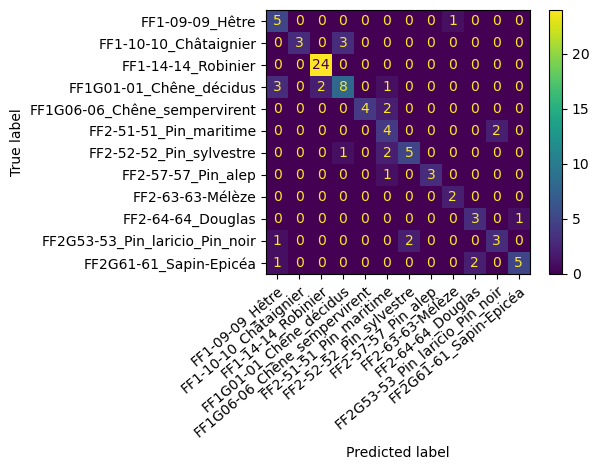

In [197]:
ConfusionMatrixDisplay(cm.values, display_labels=cm.index.values).plot()
import matplotlib.pyplot as plt
plt.xticks(rotation = 40,  rotation_mode="anchor",ha='right') # Rotates X-Axis Ticks by 45-degrees
# plt.show()
plt.tight_layout()
plt.savefig(FLAIR2_RESULTS_DIR / "CM-by-polygon-val-and-test.png")

### Ensembling

In [198]:
# Ancien modèle : geometry, 
pivot_counts_by_class = annotations_cm[[c for c in pivot.columns if c.startswith("FF")]]
pivot_freq_by_class = pivot_counts_by_class.div(pivot_counts_by_class.sum(axis=1), axis=0)
lidar_ensembling = annotations_cm[["bdforet_identifier","geometry"]].copy()
lidar_ensembling["predicted_essence_bdforetv3_lidar"] = pd.Series(pivot_freq_by_class.transpose().to_dict())
lidar_ensembling.head()

,bdforet_identifier,geometry,predicted_essence_bdforetv3_lidar
0,FORESTIE0000000002446444,"POLYGON ((539813.712 6497050.060, 539831.336 6...","{'FF1-09-09_Hêtre': 0.3333333333333333, 'FF1-1..."
1,FORESTIE0000000003215110,"POLYGON ((523300.500 6329284.500, 523307.820 6...","{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie..."
2,FORESTIE0000000001504926,"POLYGON ((665899.589 6413824.735, 665884.909 6...","{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie..."
3,FORESTIE0000000007119243,"POLYGON ((786277.233 6573804.909, 786290.995 6...","{'FF1-09-09_Hêtre': 0.0033222591362126247, 'FF..."
4,FORESTIE0000000003809798,"POLYGON ((867330.300 6478063.000, 867299.475 6...","{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie..."


In [199]:
flair2_ensembling = df_flair2[["actual_essence_bdforetv3", "percent_votes", "geometry"]].rename(columns={"percent_votes":"predicted_essence_bdforetv3_flair2"})
flair2_ensembling.head()

,actual_essence_bdforetv3,predicted_essence_bdforetv3_flair2,geometry
0,FF1-10-10_Châtaignier,{'FF1G01-01_Chêne_décidus': 0.6443000000000001...,"POLYGON ((894711.861 6472455.683, 894725.204 6..."
1,FF1G06-06_Chêne_sempervirent,"{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...","POLYGON ((793556.796 6303702.811, 793562.094 6..."
2,FF1-09-09_Hêtre,"{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...","POLYGON ((948583.906 6403477.780, 948586.705 6..."
3,FF1G06-06_Chêne_sempervirent,"{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...","POLYGON ((1197402.882 6078241.052, 1197405.335..."
4,FF2-52-52_Pin_sylvestre,{'FF1G01-01_Chêne_décidus': 0.1397199999999999...,"POLYGON ((1037876.825 6328044.487, 1037867.300..."


In [200]:
# ensemble = lidar_ensembling.sjoin(flair2_ensembling)
ensemble = gpd.overlay(lidar_ensembling,flair2_ensembling)
ensemble["shared_area"] = ensemble.area
ensemble = ensemble.sort_values("shared_area",ascending=False).drop_duplicates(subset=["bdforet_identifier"])  # keep the one with max overlay, the other is almost null.
ensemble

/tmp/ipykernel_1369020/2867556926.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ensemble = gpd.overlay(lidar_ensembling,flair2_ensembling)


,bdforet_identifier,predicted_essence_bdforetv3_lidar,actual_essence_bdforetv3,predicted_essence_bdforetv3_flair2,geometry,shared_area
11,FORESTIE0000000004608561,"{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie...",FF1G01-01_Chêne_décidus,"{'FF1G01-01_Chêne_décidus': 0.83276, 'FF1G06-0...","POLYGON ((597626.900 6426890.800, 597627.060 6...",1.816996e+07
72,FORESTIE0000000002013019,"{'FF1-09-09_Hêtre': 0.0018705574261129816, 'FF...",FF2G53-53_Pin_laricio_Pin_noir,"{'FF1G01-01_Chêne_décidus': 0.00074, 'FF1G06-0...","POLYGON ((1189434.000 6153104.300, 1189426.300...",1.722770e+07
13,FORESTIE0000000008210212,"{'FF1-09-09_Hêtre': 0.0002030456852791878, 'FF...",FF1G01-01_Chêne_décidus,"{'FF1G01-01_Chêne_décidus': 0.8806, 'FF1G06-06...","POLYGON ((598031.202 6340024.427, 598054.515 6...",1.568736e+07
71,FORESTIE0000000006008726,"{'FF1-09-09_Hêtre': 0.23200366804218248, 'FF1-...",FF2-52-52_Pin_sylvestre,"{'FF1G01-01_Chêne_décidus': 0.0141, 'FF1G06-06...","POLYGON ((673137.106 6897040.989, 673171.501 6...",1.242184e+07
9,FORESTIE0000000000600707,"{'FF1-09-09_Hêtre': 0.0013227513227513227, 'FF...",FF1G01-01_Chêne_décidus,"{'FF1G01-01_Chêne_décidus': 0.92251, 'FF1G06-0...","POLYGON ((1008017.491 6291003.455, 1008018.820...",9.822269e+06
...,...,...,...,...,...,...
33,FORESTIE0000000008109742,"{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie...",FF1-10-10_Châtaignier,"{'FF1G01-01_Chêne_décidus': 0.74115, 'FF1G06-0...","POLYGON ((625653.495 6340361.896, 625657.520 6...",1.602395e+04
4,FORESTIE0000000003809798,"{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie...",FF1G01-01_Chêne_décidus,"{'FF1G01-01_Chêne_décidus': 0.00031, 'FF1G06-0...","POLYGON ((867299.475 6478019.292, 867284.394 6...",1.570523e+04
83,FORESTIE0000000006316380,"{'FF1-09-09_Hêtre': 0.006176016469377252, 'FF1...",FF2G61-61_Sapin-Epicéa,"{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...","POLYGON ((677138.030 6494026.840, 677146.202 6...",1.531891e+04
48,FORESTIE0000000004710749,"{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie...",FF1-14-14_Robinier,"{'FF1G01-01_Chêne_décidus': 8e-05, 'FF1G06-06_...","POLYGON ((471000.000 6389751.800, 471009.058 6...",1.505086e+04


In [221]:
import numpy as np


def make_cm(decision_func):
    ensemble["consensus"] = ensemble[["predicted_essence_bdforetv3_lidar","predicted_essence_bdforetv3_flair2"]].apply(lambda x : decision_func(x["predicted_essence_bdforetv3_lidar"],x["predicted_essence_bdforetv3_flair2"]), axis=1)
    # Confusion matrix at polygon level
    counts = ensemble.groupby(["actual_essence_bdforetv3","consensus"]).size().reset_index().rename(columns={0:"count"})
    cm = counts.pivot(index="actual_essence_bdforetv3",columns="consensus",values="count").fillna(0).astype(int)
    for idx_c, c in enumerate(cm.index): # will only work for one missing columns, not more...
        if c not in cm.columns and c.contains("Pin_maritime")
            cm.insert(idx_c, c, [0 for x in range(len(cm.index))])
    ConfusionMatrixDisplay(cm.values, display_labels=cm.index.values).plot()
    import matplotlib.pyplot as plt
    plt.xticks(rotation = 40,  rotation_mode="anchor",ha='right') # Rotates X-Axis Ticks by 45-degrees
    # plt.show()
    plt.tight_layout()
    plt.savefig(FLAIR2_RESULTS_DIR / f"CM-by-polygon-val-and-test-ENSEMBLE-{decision_func.__name__}.png") # TODO: chnage the name

SyntaxError: invalid syntax (808521558.py, line 10)

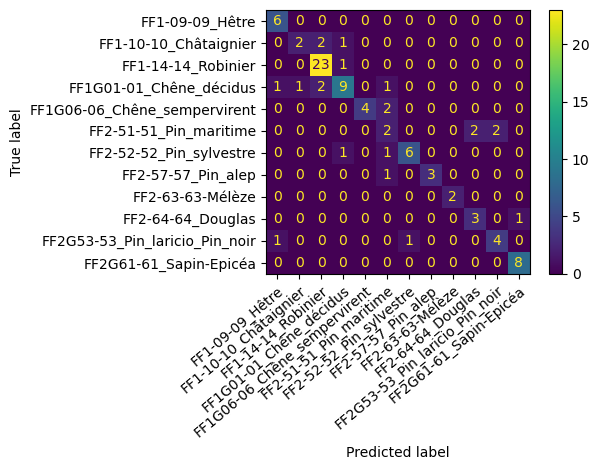

In [222]:
def predict_most_confident(predicted_essence_bdforetv3_lidar, predicted_essence_bdforetv3_flair2):
    pred_lidar = max(predicted_essence_bdforetv3_lidar, key=predicted_essence_bdforetv3_lidar.get)
    pred_flair2 = max(predicted_essence_bdforetv3_flair2, key=predicted_essence_bdforetv3_flair2.get)
    
    confidence_lidar = predicted_essence_bdforetv3_lidar[pred_lidar]
    confidence_flair2 = predicted_essence_bdforetv3_flair2[pred_flair2]
    # if confidence_flair2 == confidence_lidar:
    #     if confidence_lidar != 1:
    #         print("Weird!")
    # print(pred_lidar, confidence_lidar, pred_flair2, confidence_flair2)
    if confidence_lidar >= confidence_flair2:
        return pred_lidar
    return pred_flair2
make_cm(predict_most_confident)

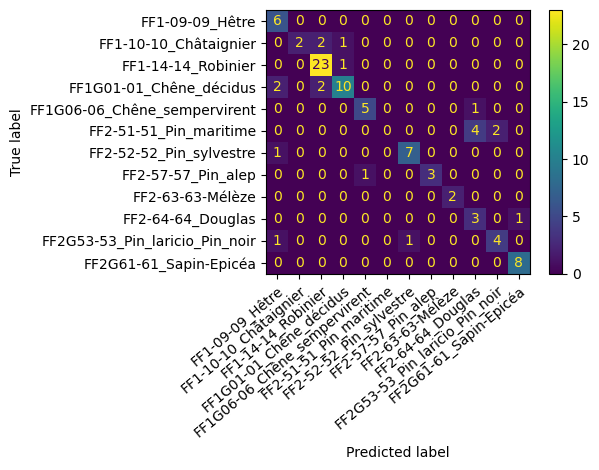

In [223]:
def predict_by_summing_confidences(predicted_essence_bdforetv3_lidar, predicted_essence_bdforetv3_flair2):
    predicted_essence_ensemble = {key: value + predicted_essence_bdforetv3_flair2[key] for key, value in predicted_essence_bdforetv3_lidar.items()}
    pred = max(predicted_essence_ensemble, key=predicted_essence_ensemble.get)
    return pred
make_cm(predict_by_summing_confidences)

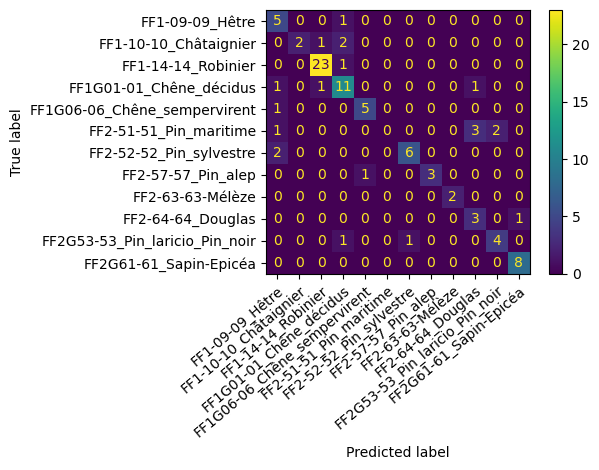

In [224]:
def predict_by_multiplying_confidences(predicted_essence_bdforetv3_lidar, predicted_essence_bdforetv3_flair2):
    predicted_essence_ensemble = {key: value * predicted_essence_bdforetv3_flair2[key] for key, value in predicted_essence_bdforetv3_lidar.items()}
    pred = max(predicted_essence_ensemble, key=predicted_essence_ensemble.get)
    return pred
make_cm(predict_by_multiplying_confidences)